## Gan Augumentation

### Setting UP

In [ ]:
# Libs
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns


## NN Imports
import tensorflow as tf
from   tensorflow.keras import Model
from   tensorflow.keras.optimizers import Adam
from   tensorflow.keras.layers import Input, Dense, Dropout

In [ ]:
df = pd.read_csv('data.csv')
# Normalization techniques
for column in df.columns:
    df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())    
# Removing Index column
df = df.iloc[:, 1:]

### EDA

In [ ]:
eda_df = df.iloc[:, 3:]

[Text(0.5, 1.0, 'TEST')]

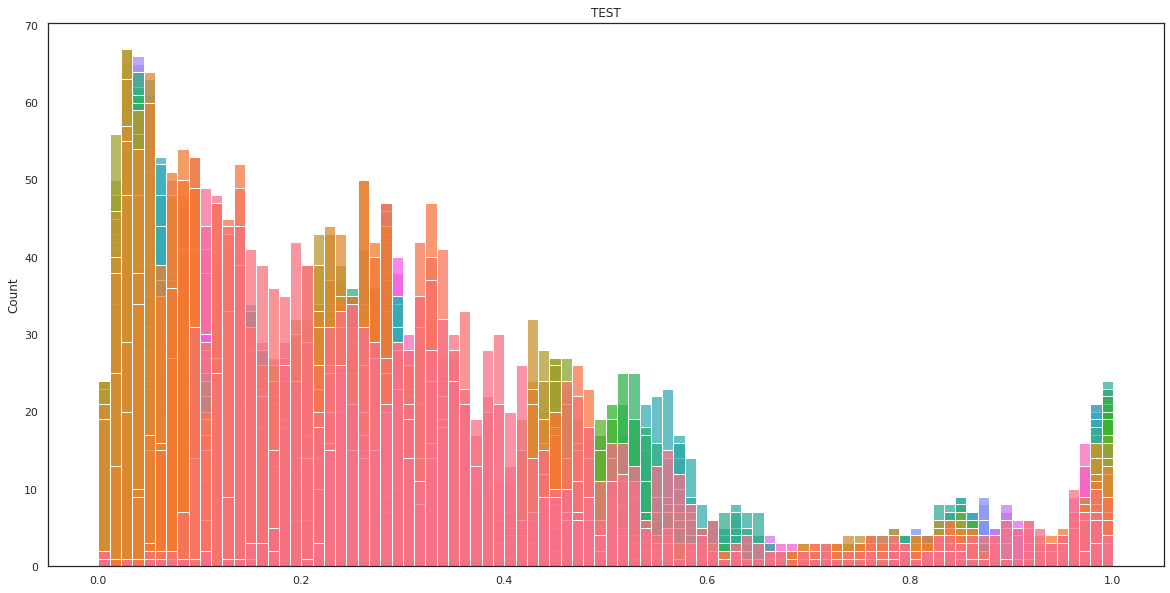

In [ ]:
plt.figure(figsize=(20,10))
sns.histplot(eda_df,  bins='auto', kde=False, legend=False).set(title='TEST')

In [ ]:
from xgboost import XGBRegressor
from matplotlib import pyplot

[19:00:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


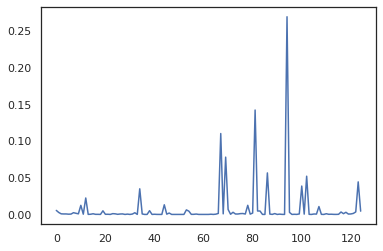

In [ ]:
# feature importance for 1st target variable
X     = df.iloc[:,2:]
y     = df.iloc[:,:1]
# fit model no training data
model = XGBRegressor()
model.fit(X, y)
# feature importance
plt.plot(model.feature_importances_)

[19:01:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


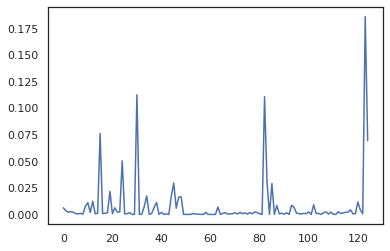

In [ ]:
# feature importance for 2nd target variable
X     = df.iloc[:,2:]
y     = df.iloc[:,1:2]
# fit model no training data
model = XGBRegressor()
model.fit(X, y)
# feature importance
plt.plot(model.feature_importances_)

### Configurations

In [ ]:
#Define the GAN and training parameters
## Dims
noise_dim     = 32
dim           = 128
batch_size    = 32


log_step      = 100
epochs        = 5000+1
learning_rate = 5e-4
models_dir    = 'model'

gan_args      = [batch_size, learning_rate, noise_dim, df.shape[1], dim]
train_args    = ['', epochs, log_step]

# Creating directory for model
!mkdir model

#### Model Defination

In [ ]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Model

from tensorflow.keras.optimizers import Adam

class GAN():
    
    def __init__(self, gan_args):
        [self.batch_size, lr, self.noise_dim,
         self.data_dim, layers_dim] = gan_args

        self.generator = Generator(self.batch_size).\
            build_model(input_shape=(self.noise_dim,), dim=layers_dim, data_dim=self.data_dim)

        self.discriminator = Discriminator(self.batch_size).\
            build_model(input_shape=(self.data_dim,), dim=layers_dim)

        optimizer = Adam(lr, 0.5)

        # Build and compile the discriminator
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.noise_dim,))
        record = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(record)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

        self.best_accuracy = 0

    def get_data_batch(self, train, batch_size, seed=0):
        # # random sampling - some samples will have excessively low or high sampling, but easy to implement
        # np.random.seed(seed)
        # x = train.loc[ np.random.choice(train.index, batch_size) ].values
        # iterate through shuffled indices, so every sample gets covered evenly

        start_i = (batch_size * seed) % len(train)
        stop_i = start_i + batch_size
        shuffle_seed = (batch_size * seed) // len(train)
        np.random.seed(shuffle_seed)
        train_ix = np.random.choice(list(train.index), replace=False, size=len(train))  # wasteful to shuffle every time
        train_ix = list(train_ix) + list(train_ix)  # duplicate to cover ranges past the end of the set
        x = train.loc[train_ix[start_i: stop_i]].values
        return np.reshape(x, (batch_size, -1))
        
    def train(self, data, train_arguments):
        [cache_prefix, epochs, sample_interval] = train_arguments
        
        data_cols = data.columns

        # Adversarial ground truths
        valid = np.ones((self.batch_size, 1))
        fake = np.zeros((self.batch_size, 1))

        for epoch in range(epochs):    
            # ---------------------
            #  Train Discriminator
            # ---------------------
            batch_data = self.get_data_batch(data, self.batch_size)
            noise = tf.random.normal((self.batch_size, self.noise_dim))

            # Generate a batch of new images
            gen_data = self.generator.predict(noise)
    
            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(batch_data, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
            # ---------------------
            #  Train Generator
            # ---------------------
            noise = tf.random.normal((self.batch_size, self.noise_dim))
            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)
    
            # Plot the progress
            if epoch % 100 ==0 or epoch == epochs :
              print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
    
              # If at save interval => save generated events
              # if epoch % sample_interval == 0:
              if 100 * d_loss[1] > self.best_accuracy:
                  #Test here data generation step
                  # save model checkpoints
                  model_checkpoint_base_name = 'model/' + cache_prefix + '_{}_model_weights_step_{}.h5'
                  self.generator.save_weights(model_checkpoint_base_name.format('generator', epoch))
                  self.discriminator.save_weights(model_checkpoint_base_name.format('discriminator', epoch))

                  #Here is generating the data
                  z = tf.random.normal((432, self.noise_dim))
                  gen_data = self.generator(z)
                  self.best_accuracy = 100 * d_loss[1]
                  print('Saving Model')
        model_checkpoint_base_name = 'model/' + cache_prefix + '_{}_model_weights_step_epochs.h5'
        self.generator.save_weights(model_checkpoint_base_name)
        self.discriminator.save_weights(model_checkpoint_base_name)

    def save(self, path, name):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        model_path = os.path.join(path, name)
        self.generator.save_weights(model_path)  # Load the generator
        return
    
    def load(self, path):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        self.generator = Generator(self.batch_size)
        self.generator = self.generator.load_weights(path)
        return self.generator
    
class Generator():
    def __init__(self, batch_size):
        self.batch_size=batch_size
        
    def build_model(self, input_shape, dim, data_dim):
        input= Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim, activation='relu')(input)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dense(dim * 4, activation='relu')(x)
        x = Dense(data_dim)(x)
        return Model(inputs=input, outputs=x)

class Discriminator():
    def __init__(self,batch_size):
        self.batch_size=batch_size
    
    def build_model(self, input_shape, dim):
        input = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim * 4, activation='relu')(input)
        x = Dropout(0.1)(x)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dropout(0.1)(x)
        x = Dense(dim, activation='relu')(x)
        x = Dense(1, activation='sigmoid')(x)
        return Model(inputs=input, outputs=x)

### Model Training

In [ ]:
model = GAN

#Training the GAN model chosen: Vanilla GAN, CGAN, DCGAN, etc.
synthesizer = model(gan_args)
synthesizer.train(df, train_args)

In [ ]:
# creating directories for saving models
!mkdir model/gan
!mkdir model/gan/saved

In [ ]:
synthesizer.save('model/gan/saved', 'generator_patients')

In [ ]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

### Inference

In [ ]:
# Setup parameters visualization parameters
seed = 17
test_size    = 500 # number of fraud cases
noise_dim    = 32

np.random.seed(seed)
z            = np.random.normal(size=(test_size, noise_dim))
real         = synthesizer.get_data_batch(train=df, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=df.columns)

model_names = ['GAN']
colors      = ['deepskyblue','blue']
markers     = ['o','^']

base_dir    = 'model/'

#Actual fraud data visualization#
model_steps = [ 4000]
rows        = len(model_steps)
columns     = 5

axarr       = [[]]*len(model_steps)


for model_step_ix, model_step in enumerate(model_steps):       
    [model_name, with_class, generator_model] = models['GAN']
    generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')
    g_z = generator_model.predict(z)
    gen_samples = pd.DataFrame(g_z, columns=df.columns)
    gen_samples.to_csv('Generated_sample.csv')

In [ ]:
gen_samples.head()

### Evaluation

In [ ]:
cosine_similarity = []

for col in df.columns:
  a = gen_samples[col].values
  b = df[col][:len(gen_samples[col])].values
  cosine_similarity.append(1 - spatial.distance.cosine(a, b))

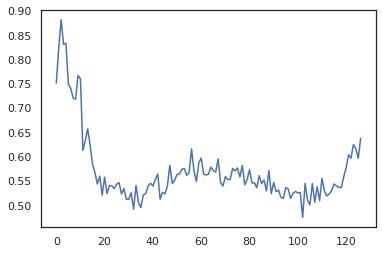

In [ ]:
plt.plot(cosine_similarity)

In [ ]:
!pip install table_evaluator -q

679 492


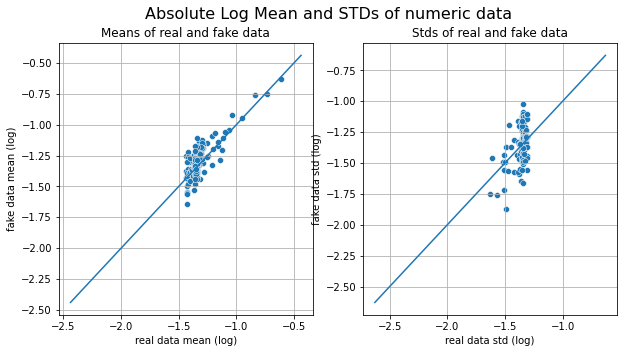

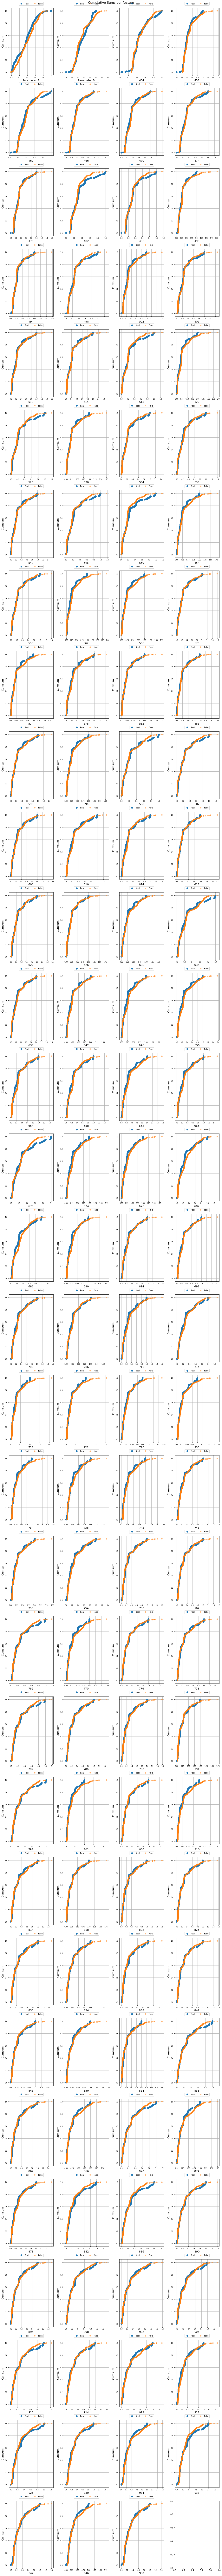

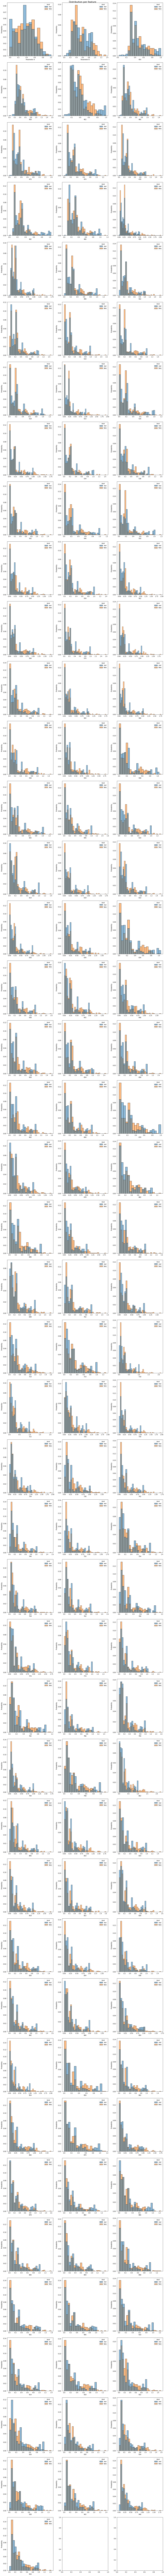

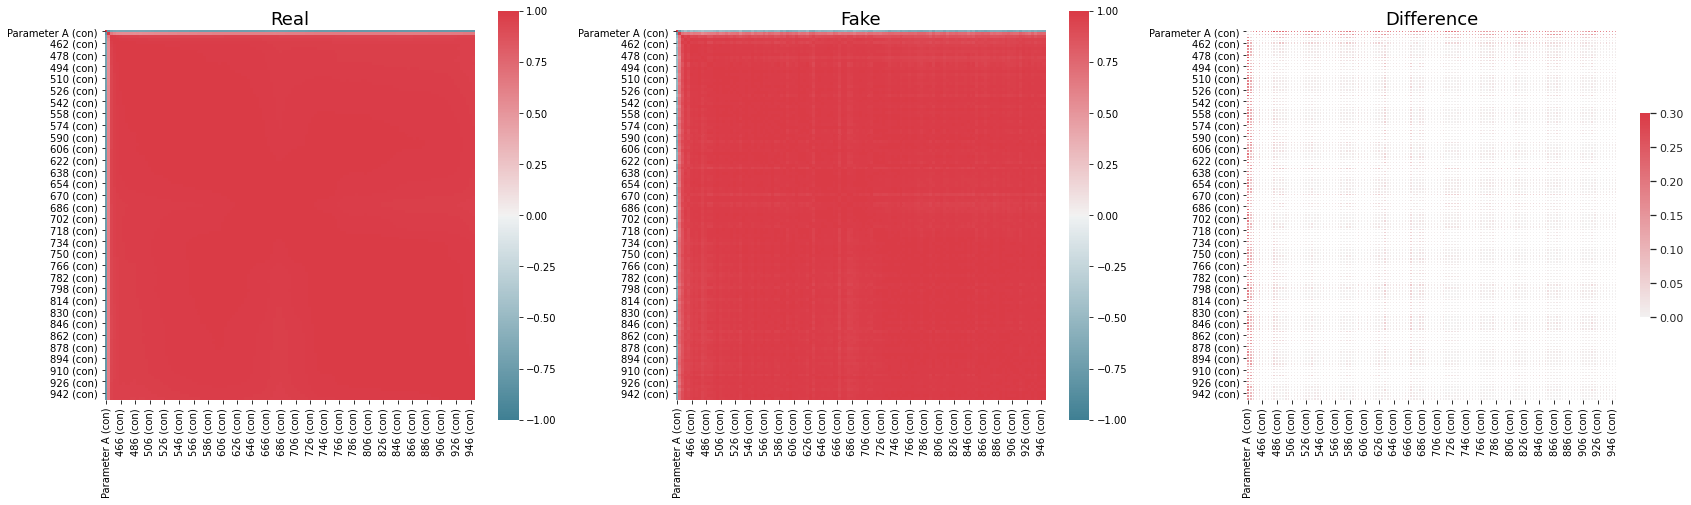

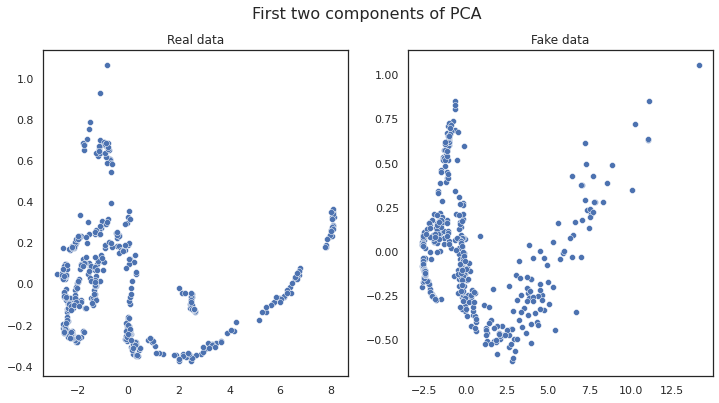

In [ ]:
from table_evaluator import TableEvaluator


print(len(df), len(gen_samples))
table_evaluator =  TableEvaluator(df, gen_samples)

table_evaluator.visual_evaluation()

### Conclusion

In [ ]:
'''

Generated data lines up with the actual distribution along with similar orthogonal vectors which validates the similar distribution.

'''

'\n\nGenerated data lines up with the actual distribution along with similar orthogonal vectors which validates the similar distribution.\n\n'